In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA, IncrementalPCA, TruncatedSVD
from sklearn.utils.extmath import randomized_svd
from sklearn.datasets import fetch_openml
from tools.oja_pca import OjaPCA
import torch
import sys
import os
sys.path.append(os.path.abspath(".."))
from online_svd_buffer import fit_batched

from scipy.sparse.linalg import svds


import os, sys
from pathlib import Path
# repo_root = Path(r"D:\PyParSVD")
# assert (repo_root / "pyparsvd").is_dir(), "pyparsvd/ not found under D:\\PyParSVD"

# # Put repo root (the parent of 'pyparsvd/') on sys.path
# sys.path.insert(0, str(repo_root))

# from pyparsvd.parsvd_serial   import ParSVD_Serial
# from pyparsvd.parsvd_parallel import ParSVD_Parallel


In [2]:
def load_mnist_subset(n_samples=5000):
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data.astype(np.float32).T[:, :n_samples] / 255.0

    return X  # shape: (784, n_samples)

def load_fashion_mnist_subset(n_samples=5000):
    fmnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
    X = fmnist.data.astype(np.float32).T[:, :n_samples] / 255.0
    return X  # shape: (784, n_samples)

def load_usps_subset(n_samples=5000):
    usps = fetch_openml('USPS', version=1, as_frame=False)
    X = usps.data.astype(np.float32).T[:, :n_samples] / 255.0

    return X  # shape: (256, n_samples) since USPS has 16x16 images

def load_isolet_subset(n_samples=5000):
    isolet = fetch_openml('isolet', version=1, as_frame=False)
    # Features are already real-valued, just normalize by max
    X = isolet.data.astype(np.float32).T[:, :n_samples]
    print(X.shape)
    X /= np.max(X)  # scale to [0,1]
    return X  # shape: (617, n_samples), 617 audio features

def load_mnist_and_fashion(n_samples=5000):
    # Load MNIST
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X_mnist = mnist.data.astype(np.float32)[:n_samples] / 255.0
    y_mnist = mnist.target.astype(int)[:n_samples]

    # Load Fashion-MNIST
    fmnist = fetch_openml('Fashion-MNIST', version=1, as_frame=False)
    X_fmnist = fmnist.data.astype(np.float32)[:n_samples] / 255.0
    y_fmnist = fmnist.target.astype(int)[:n_samples]

    # Stack them together
    X = np.vstack([X_mnist, X_fmnist]).T   # shape: (784, 2*n_samples)
    return X

In [3]:
def load_mnist_isolet_combined(n_samples=5000):
    X_mnist = load_mnist_subset(n_samples).astype(np.float32, copy=False)   # (784, n)
    X_iso   = load_isolet_subset(n_samples).astype(np.float32, copy=False)  # (617, n)

    d_mnist, _ = X_mnist.shape
    d_iso,   _ = X_iso.shape
    d_common = min(d_mnist, d_iso)

    if d_mnist > d_common:
        X_mnist = X_mnist[:d_common, :]
    if d_iso > d_common:
        X_iso = X_iso[:d_common, :]

    X_combined = np.concatenate([X_mnist, X_iso], axis=1).astype(np.float32, copy=False)

    mu = X_combined.mean(axis=1, keepdims=True).astype(X_combined.dtype)
    X_combined = X_combined - mu

    print(X_combined.shape)  # (d_common, 2*n_samples)
    return X_combined

In [4]:
from matplotlib.ticker import FuncFormatter
def explained_variance_ratio(X, X_recon):
    error = np.linalg.norm(X - X_recon, 'fro') ** 2
    total = np.linalg.norm(X, 'fro') ** 2
    return 1 - error / total

def plot_traces(traces, X, p):

    traces = np.array(traces)
    u, s, vt = np.linalg.svd(X)
    aux = u.transpose() @ X @ vt.transpose()
    true_energy = np.trace(aux[:p, :p])


    true_energy = np.sum(np.linalg.svd(X, compute_uv=False)[:p])

    print(true_energy)
    print(traces[:-20])
    
    plt.rcParams.update({
    "figure.dpi": 300,
    "font.size": 11,
    "axes.titlepad": 8,
    })

    fig, ax = plt.subplots(figsize=(6.0, 4.2))

    # Data
    ax.plot(traces, label='OnlinePCA', linewidth=2)
    ax.axhline(true_energy, linestyle=':', linewidth=2,
            label='Sum of first p singular values')

    # Y-limit: 5% above the red line (and safe if traces ever exceed it)
    y_top = 1.10 * max(true_energy, np.nanmax(traces))
    y_bottom = min(0, float(np.nanmin(traces)))
    ax.set_ylim(y_bottom, y_top)

    # Clean up axes
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.grid(axis='y', linestyle='--', linewidth=0.6, alpha=0.4)
    ax.margins(x=0)  # no extra horizontal padding

    # Tick formatting: show iterations as “k”
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, pos: f'{int(x/1000)}k' if x >= 1000 else f'{int(x)}')
    )

    # Labels & legend
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Trace')
    ax.set_title('Trace progression vs. True energy (random)')
    ax.legend(frameon=False, loc='lower right')

    plt.tight_layout()
    plt.savefig('trace_mnist.pdf', bbox_inches='tight')
    plt.show()

In [5]:
def benchmark(method_name, fit_fn):
    start = time.time()
    U, S, Vt, X_recon, traces = fit_fn()
    elapsed = time.time() - start
    # if traces is not None:
    #     plot_traces(traces, X, p)
    evr = explained_variance_ratio(X, X_recon)
    
    return {
        "method": method_name,
        "time": elapsed,
        "explained_variance": evr,
        "traces": traces
    }

In [14]:
from tqdm import tqdm
sys.path.append(os.path.abspath(".."))
# from online_psp.online_psp.fast_similarity_matching import FSM
# from online_psp.online_psp.similarity_matching import SM
# from online_psp.online_psp.incremental_pca import IPCA

def run_benchmarks(X, p=50, g=200):
    results = []

    #sklearn PCA (full SVD)
    def run_pca():
        model = PCA(n_components=p, svd_solver="full")
        model.fit(X.T)
        X_recon = model.inverse_transform(model.transform(X.T)).T
        print("Done PCA")
        return model.components_.T, model.singular_values_, None, X_recon, None
    results.append(benchmark("PCA", run_pca))

    def run_online_pca():
        batch_sz = X.shape[0] * 2
        traces, U, X_approx = fit_batched(X, p, g, batch_sz)

        X_reduced = U.T[:p, :] @ X
        X_recon = U[:, :p] @ X_reduced

        print("Done OnlinePCA")
        return U, None, None, X_recon, np.array(traces)

    
    results.append(benchmark("OnlinePCA", run_online_pca))

    # Incremental PCA
    def run_incpca():
        batch_sz = X.shape[0] * 2
        model = IncrementalPCA(n_components=p, batch_size=batch_sz)
        model = IncrementalPCA(n_components=p, batch_size=batch_sz)
        model.fit(X.T)
        # X_batches = np.array_split(X.T, max(1, X.shape[1] // batch_sz), axis=0)
        
        explained_variances = []
        
        # for batch in X_batches:
        #     model.partial_fit(batch)
            
        #     # X_recon = model.inverse_transform(model.transform(X.T)).T
            
        #     # evr = explained_variance_ratio(X, X_recon) 
        #     # explained_variances.append(evr)
        
        X_recon_final = model.inverse_transform(model.transform(X.T)).T
        
        print("Done Incremental PCA with tracked explained variance")
        return model.components_.T, None, None, X_recon_final, np.array(explained_variances)
    
    results.append(benchmark("IncrementalPCA", run_incpca))

    def run_oja():
        model = OjaPCA(
            n_features=X.shape[0],
            n_components=p,
            eta=0.001,
        )

        X_tensor = torch.tensor(X.T, dtype=torch.float32)
        b_size = X.shape[0] * 2

        explained_variances = []

        for i in range(0, len(X_tensor), b_size):
            batch = X_tensor[i : i + b_size]

            if len(batch) < b_size:
                batch = torch.cat([batch, X_tensor[: b_size - len(batch)]], dim=0)

            if hasattr(model, "forward"):
                model(batch)
            else:
                model.partial_fit(batch)

            # after each batch: compute reconstruction + explained variance
            with torch.no_grad():
                recon = model.inverse_transform(model.transform(X_tensor))
                evr = explained_variance_ratio(X, np.array(recon).T)
                explained_variances.append(evr)

        recon = model.inverse_transform(model.transform(X_tensor))
        print("Done Oja PCA")

        return (
            np.array(model.get_components()),
            None,
            None,
            np.array(recon).T,
            np.array(explained_variances),
        )
    results.append(benchmark("OjaPCA", run_oja))

    # def run_ccipca():
    #     sigma2_0 = 1e-8 * np.ones(p)
    #     Uhat0 = (X[:, :p] / np.sqrt((X[:, :p] ** 2).sum(0))).astype(np.float64)
    #     ccipca = CCIPCA(p, X.shape[0], Uhat0=Uhat0, sigma2_0=sigma2_0, cython=True)
    #     n_epoch = 1
    #     for n_e in range(n_epoch):
    #         for x in tqdm(X.T):
    #             ccipca.fit_next(x.astype(np.float64))
    #     X_reduced = ccipca.get_components().T @ X
    #     X_recon = ccipca.get_components() @ X_reduced
    #     print("Done ccipca")
    #     return np.array(ccipca.get_components()), None, None, np.array(X_recon), None
    # results.append(benchmark("CCIPCA", run_ccipca))

    # def run_fsm():
    #     scal = 100
    #     Uhat0 = X[:, :p] / np.sqrt((X[:, :p] ** 2).sum(0)) / scal
    #     Minv0    = np.eye(p) * scal


    #     errs = []
    #     D = X.shape[0]
    #     fsm = FSM(p, D, W0=Uhat0.T, Minv0=Minv0)

    #     time_1 = time.time()
    #     for n_e in range(3):
    #         for x in X.T:
    #             fsm.fit_next(x)
    #     X_reduced = fsm.get_components().T @ X
    #     X_recon = fsm.get_components() @ X_reduced
    #     print("Done FSM")
    #     return np.array(fsm.get_components()), None, None, np.array(X_recon), None
    # results.append(benchmark("FSM", run_fsm))

    # def run_sm():
    #     scal = 100
    #     Uhat0 = X[:, :p] / np.sqrt((X[:, :p] ** 2).sum(0)) / scal
    #     M0    = np.eye(p) / scal

    #     errs = []
    #     D = X.shape[0]
    #     sm = SM(p, D, W0=Uhat0.T, M0=M0)

    #     time_1 = time.time()
    #     for n_e in range(5):
    #         for x in tqdm(X.T):
    #             sm.fit_next(x)
    #     X_reduced = sm.get_components().T @ X
    #     X_recon = sm.get_components() @ X_reduced
    #     print("Done SM")
    #     return np.array(sm.get_components()), None, None, np.array(X_recon), None
    # results.append(benchmark("SimilarityMatching", run_sm))

    # def run_ipca2():
    #     sigma2_0 = lambda0 = np.zeros(p)
    #     Uhat0 = X[:, :p] / np.sqrt((X[:, :p] ** 2).sum(0))

    #     errs = []
    #     D = X.shape[0]
    #     ipca = IPCA(p, D, Uhat0=Uhat0, sigma2_0=sigma2_0)
    #     for n_e in range(1):
    #         for x in tqdm(X.T):
    #             ipca.fit_next(x)
    #     X_reduced = ipca.get_components().T @ X
    #     X_recon = ipca.get_components() @ X_reduced
    #     print("Done IPCA2")
    #     return np.array(ipca.get_components()), None, None, np.array(X_recon), None
    # results.append(benchmark("StochasticPCA", run_ipca2))

    # def run_parsvd():
    #     N = X.shape[1]
    #     batch_size = 2 * X.shape[0]  # change as you like
    #     ParSVD = ParSVD_Parallel(K=p, ff=1.0, low_rank=True)
    #     first = True
    #     for start in range(0, N, batch_size):
    #         end = min(start + batch_size, N)
    #         batch = X[:, start:end]
    #         if first:
    #             ParSVD.initialize(batch)
    #             first = False
    #         else:
    #             ParSVD.incorporate_data(batch)
    #         print(f"Processed cols [{start}:{end})")

    #     U = ParSVD.modes
    #     X_recon = U @ (U.T @ X)
    #     return None, None, None, np.array(X_recon), None
    # results.append(benchmark("ParSVD", run_parsvd))
    return results

In [7]:
X = load_mnist_subset(n_samples=50000)
#X = np.random.rand(500,10000).astype(np.float32)
n_samples = 50000
# X = load_usps_subset(n_samples=9298)
# n_samples = 9298

# X = load_isolet_subset(n_samples=4704)
# n_samples = 4704

repeats = int(np.ceil(n_samples / X.shape[1]))
X = np.tile(X, (1, repeats))[:, :n_samples]

print(X.shape)

(784, 50000)


In [8]:
temp = X.copy()
# numba warmup
_, _, _ = fit_batched(temp, 15, 100, 1576)

Total batches: 32


d:\online_pca\online_svd_buffer.py:226: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "online_svd_buffer.py", line 86:
@njit(parallel=True)
def compute_score_cf_numba(i, j, x, d):
^

  val = compute_score_cf_numba(iq, s, x, d)[2]
d:\online_pca\online_svd_buffer.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "online_svd_buffer.py", line 86:
@njit(parallel=True)
def compute_score_cf_numba(i, j, x, d):
^

  val = compute_score_cf_numba(r, iq, x, d)[2]


Done batch 0


d:\online_pca\online_svd_buffer.py:226: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "online_svd_buffer.py", line 86:
@njit(parallel=True)
def compute_score_cf_numba(i, j, x, d):
^

  val = compute_score_cf_numba(iq, s, x, d)[2]
d:\online_pca\online_svd_buffer.py:292: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "online_svd_buffer.py", line 86:
@njit(parallel=True)
def compute_score_cf_numba(i, j, x, d):
^

  val = compute_score_cf_numba(r, iq, x, d)[2]


Done batch 1
Done batch 2
Done batch 3
Done batch 4
Done batch 5
Done batch 6
Done batch 7
Done batch 8
Done batch 9
Done batch 10
Done batch 11
Done batch 12
Done batch 13
Done batch 14
Done batch 15
Done batch 16
Done batch 17
Done batch 18
Done batch 19
Done batch 20
Done batch 21
Done batch 22
Done batch 23
Done batch 24
Done batch 25
Done batch 26
Done batch 27
Done batch 28
Done batch 29
Done batch 30
Done batch 31


Done PCA
Total batches: 32
Done batch 0
Done batch 1
Done batch 2
Done batch 3
Done batch 4
Done batch 5
Done batch 6
Done batch 7
Done batch 8
Done batch 9
Done batch 10
Done batch 11
Done batch 12
Done batch 13
Done batch 14
Done batch 15
Done batch 16
Done batch 17
Done batch 18
Done batch 19
Done batch 20
Done batch 21
Done batch 22
Done batch 23
Done batch 24
Done batch 25
Done batch 26
Done batch 27
Done batch 28
Done batch 29
Done batch 30
Done batch 31
Done OnlinePCA
Done Incremental PCA with tracked explained variance


C:\Users\seraf\AppData\Local\Temp\ipykernel_8648\2786223141.py:83: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  evr = explained_variance_ratio(X, np.array(recon).T)


Done Oja PCA


C:\Users\seraf\AppData\Local\Temp\ipykernel_8648\2786223141.py:90: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(model.get_components()),
C:\Users\seraf\AppData\Local\Temp\ipykernel_8648\2786223141.py:93: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  np.array(recon).T,



Benchmark Results:
PCA             | Time: 3.85s | Explained Var: 74.81%
OnlinePCA       | Time: 6.46s | Explained Var: 71.23%
OjaPCA          | Time: 21.35s | Explained Var: 74.54%
IncrementalPCA  | Time: 22.40s | Explained Var: 74.75%


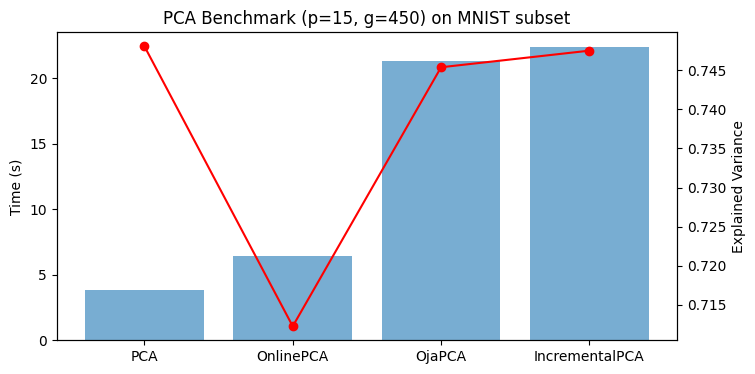

In [15]:
p = 15
g = 450

results = run_benchmarks(X, p=p, g=g)
results.sort(key=lambda d: d["time"]) 
print("\nBenchmark Results:")
for r in results:
    print(f"{r['method']:15s} | Time: {r['time']:.2f}s | Explained Var: {r['explained_variance']*100:.2f}%")

methods = [r["method"] for r in results]
times = [r["time"] for r in results]
evrs = [r["explained_variance"] for r in results]

fig, ax1 = plt.subplots(figsize=(8,4))
ax2 = ax1.twinx()

ax1.bar(methods, times, alpha=0.6, label="Time (s)")
ax2.plot(methods, evrs, "o-", color="red", label="Explained Var")

ax1.set_ylabel("Time (s)")
ax2.set_ylabel("Explained Variance")
plt.title(f"PCA Benchmark (p={p}, g={g}) on MNIST subset")
plt.show()

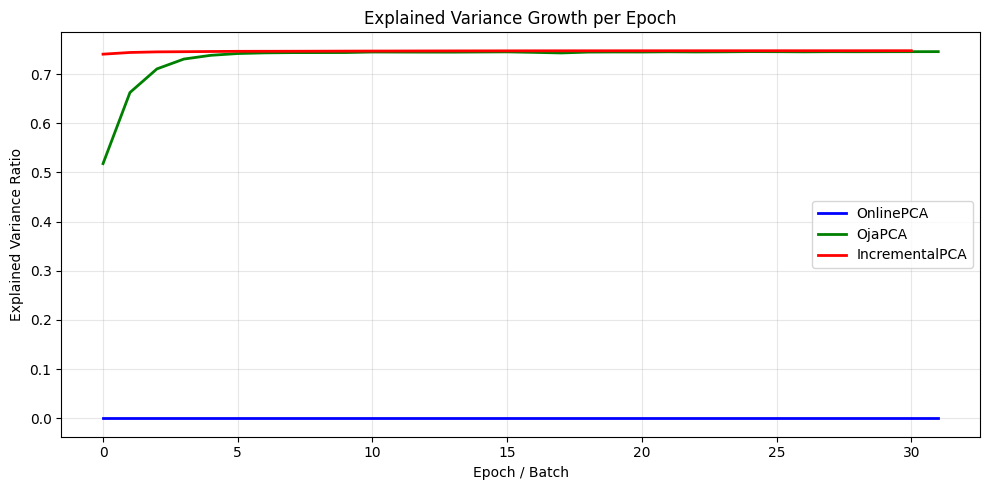

In [10]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 5))

# Colors for each method
colors = {
    "OnlinePCA": "blue",
    "OjaPCA": "green",
    "IncrementalPCA": "red",
}

for r in results:
    traces = r.get("traces", None)
    if traces is not None:
        traces = np.array(traces, dtype=float)
        color = colors.get(r["method"], "black")
        plt.plot(traces, label=r["method"], color=color, lw=2)

plt.xlabel("Epoch / Batch")
plt.ylabel("Explained Variance Ratio")
plt.title("Explained Variance Growth per Epoch")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [11]:
results

[{'method': 'PCA',
  'time': 3.513977527618408,
  'explained_variance': np.float32(0.7480686),
  'traces': None},
 {'method': 'OnlinePCA',
  'time': 8.130197286605835,
  'explained_variance': np.float64(0.7101731595576108),
  'traces': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)},
 {'method': 'OjaPCA',
  'time': 23.04683828353882,
  'explained_variance': np.float32(0.7456249),
  'traces': array([0.5179, 0.6626, 0.7105, 0.7305, 0.7382, 0.7418, 0.7431, 0.7436, 0.7437, 0.7438, 0.7449, 0.7447, 0.7446, 0.7446, 0.7449, 0.7452, 0.7441, 0.743 , 0.7447, 0.7449, 0.7449, 0.7453, 0.745 , 0.7452,
         0.7456, 0.7455, 0.7452, 0.7455, 0.7454, 0.7455, 0.7455, 0.7456], dtype=float32)},
 {'method': 'IncrementalPCA',
  'time': 64.49412274360657,
  'explained_variance': np.float64(0.7475098141225857),
  'traces': array([0.7405, 0.7439, 0.7451, 0.7455, 0.7459, 0.7463, 0.7463, 0.7464, 0.7465, 0.746